# Analyze model

First: Create model similar to `exp_regression.ipynb`

In [1]:
# To make realitve imports work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, COL_STUDENT, COL_STUDENT_PRED, COL_SALARY, COL_SALARY_PRED
from src.dataLoading import getAllCourses, getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedBruttoSalary
import numpy as np
from statsmodels.tsa.api import VAR
import statsmodels
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

In [2]:
courses = getAllCourses() # if you use all options, dont put that in the title down marked  there
courses = ['"Informatik"']
interestingYears = YEARS[3:-4]
totalStudents = getTotalStudentsFor(courses = courses, years = interestingYears)

SECTOR = ('WZ08-62', 'Dienstleistungen der Informationstechnologie')
inflationAdjasutedBruttoSalary = getInflationAdjustedBruttoSalary(SECTOR)
salaries = getSalaries()
SALARY_YEARS = salaries.index.levels[2]

years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)
newVal = (graduatesInBW[4] + graduatesInBW[6])/2
#Use average of 2011 and 2013 for 2012
#graduatesInBW[5] = newVal

#Use the averrage and add 1/4 of the missing student to 2012 and the next 3 years
diff = graduatesInBW[5] - newVal
graduatesInBW[5] = newVal + diff/4
graduatesInBW[6] = graduatesInBW[6] + diff/4
graduatesInBW[7] = graduatesInBW[7] + diff/4
graduatesInBW[8] = graduatesInBW[8] +  diff/4

Create cummulative inflation:
2.3 -> 1.023
2.8 -> 1.051644
0.2 -> 1.053747288
1.1 -> 1.065338508168
2.5 -> 1.0919719708722
2.2 -> 1.1159953542313885
1.6 -> 1.1338512798990907
0.8 -> 1.1429220901382835
0.7 -> 1.1509225447692513
0.4 -> 1.1555262349483282
1.7 -> 1.1751701809424497
1.9 -> 1.1974984143803562
1.4 -> 1.2142633921816812
0.4 -> 1.219120445750408
3.2 -> 1.258132300014421

Adjust salary for inflation:
4211.5 -> 4116.813294232649
4251.0 -> 4155.4252199413495
4302.5 -> 4091.2133763897286
4317.0 -> 4105.001312231135
4349.0 -> 4127.175509276376
4375.0 -> 4151.8493568829945
4428.0 -> 4156.425367195795
4491.5 -> 4216.030834859963
4538.0 -> 4155.784325100693
4593.0 -> 4206.151918287238
4584.0 -> 4107.54398091299
4598.0 -> 4120.0888360030385
4597.0 -> 4054.323597367301
4655.5 -> 4105.9176653346685
4805.0 -> 4204.136083692842
4854.0 -> 4247.008647293455
4927.5 -> 4281.348056300275
5012.5 -> 4355.20185331408
4930.0 -> 4266.4544091640255
4999.0 -> 4326.1674627608445
5064.0 -> 4309.163117071

/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4
/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4


### Test model accuracy
Delete last 2 timesteps and use them as a test set.

In [3]:
PAST_STEPS = 4
PREDICTION_STPES = 2

In [4]:
completeData = np.column_stack((totalStudents, inflationAdjasutedBruttoSalary, graduatesInBW.repeat(2)))
trainData, testData = np.split(completeData, [len(completeData) - PREDICTION_STPES])
completeDataDF = pd.DataFrame(completeData, index = YEARS[3:-4], columns = ['students', 'sallary', 'graduates'])

In [5]:
model = VAR(completeDataDF)

results = model.fit(maxlags=PAST_STEPS)
# Forecasting
lagged_values = trainData[-PAST_STEPS:]  # Use the last available values as lagged values
forecast = results.forecast(lagged_values, steps=PREDICTION_STPES)

/Users/paulkaifler/miniconda3/envs/dataLiteracy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/paulkaifler/miniconda3/envs/dataLiteracy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [6]:
print("These are the absoulue diffrences between the predicted and the actual values")
np.set_printoptions(suppress=True)
absDiffernce = abs(forecast - testData)
print(absDiffernce)

print("\nThese are the percentage differences between the predicted and the actual values")
percentage_difference = (absDiffernce / testData) * 100
print(percentage_difference)

These are the absoulue diffrences between the predicted and the actual values
[[  5.69713335  35.69372717 100.29157293]
 [ 12.44251521  42.53482269 711.28491538]]

These are the percentage differences between the predicted and the actual values
[[0.46697814 0.81265709 0.22749591]
 [0.99540122 0.95689646 1.61343975]]


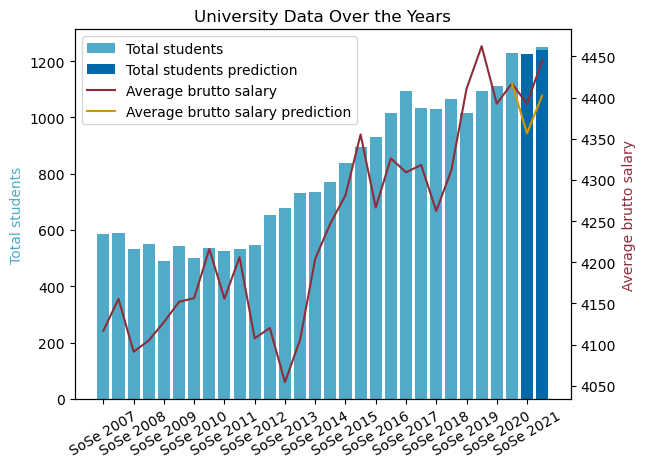

In [7]:
fig, ax1 = plt.subplots()
plt.title('University Data Over the Years')
plt.xticks(rotation=30)

ax1.set_ylabel('Total students', color=COL_STUDENT)
ax1.bar(interestingYears[:-PREDICTION_STPES], trainData[:, 0], color=COL_STUDENT, label='Total students')
ax1.bar(interestingYears[-PREDICTION_STPES:], testData[:, 0], color=COL_STUDENT)
ax1.bar(interestingYears[-PREDICTION_STPES:], forecast[:, 0], color=COL_STUDENT_PRED, label='Total students prediction')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
forecastWithPrevious = np.concatenate((trainData[-1, :].reshape(1, -1), forecast))

ax2.set_ylabel('Average brutto salary', color=COL_SALARY)
ax2.plot(interestingYears, completeData[:, 1], color=COL_SALARY, label='Average brutto salary')
ax2.plot(interestingYears[-PREDICTION_STPES -1:], forecastWithPrevious[:, 1], color=COL_SALARY_PRED, label='Average brutto salary prediction')


# Create one legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Get current ticks, keep only every second tick
locs, labels = plt.xticks()
plt.xticks(locs[::2], labels[::2])

plt.show()

Documentation Link: [statsmodel](https://www.statsmodels.org/dev/vector_ar.html#statistical-tests)

In [8]:
with open('summary.txt', 'w') as file:
    file.write(str(results.summary()))

In [9]:
# Convert forecast array to pandas DataFrame
forecast_df = pd.DataFrame(forecast, columns=completeDataDF.columns)

# Calculate standard errors for predicted values
# std_errors_pred = np.sqrt(np.einsum('ij,ij->i', forecast_df.cov(), forecast_df.cov()))
# print(std_errors_pred)
print(np.sqrt(np.sum(results.resid**2)/results.df_resid))
print(results.resid)
print(results.df_resid)
# print(np.sqrt(results.mse_resid))

students       44.780319
sallary        47.271732
graduates    2091.332569
dtype: float64
                 students    sallary    graduates
SoSe 2009      -22.583261 -10.653234 -1325.192094
WiSe 2009/2010  31.466387 -25.902519 -1215.871621
SoSe 2010      -15.296044  -5.160964 -1197.097793
WiSe 2010/2011  -8.814681  23.537077 -1279.515686
SoSe 2011       -5.873960  12.860863   669.172137
WiSe 2011/2012 -54.306436  38.555626  -715.899425
SoSe 2012       -6.035204  -7.590488  2732.093050
WiSe 2012/2013  36.054500   7.065697   350.420912
SoSe 2013       36.268713 -59.655896  2259.158485
WiSe 2013/2014  -3.586937 -27.897773   866.031647
SoSe 2014       29.091757  70.438174 -1448.683849
WiSe 2014/2015  -5.604938 -22.997767   919.329721
SoSe 2015       32.445120  -8.085401  2266.295755
WiSe 2015/2016   2.550506  64.735080  1518.754058
SoSe 2016      -23.866363 -25.848964 -4465.420843
WiSe 2016/2017 -27.620337  15.499171  -489.497498
SoSe 2017       30.199803  -6.293082  -600.189566
WiSe 2017/

/Users/paulkaifler/miniconda3/envs/dataLiteracy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [10]:
# The errors
results.bse


,students,sallary,graduates
const,1345.318684,1420.167283,62829.136931
L1.students,0.270235,0.285270,12.620522
L1.sallary,0.213707,0.225597,9.980550
L1.graduates,0.005496,0.005801,0.256658
L2.students,0.289651,0.305766,13.527309
L2.sallary,0.222681,0.235070,10.399670
L2.graduates,0.006497,0.006858,0.303409
L3.students,0.293525,0.309855,13.708208
L3.sallary,0.234716,0.247775,10.961710
L3.graduates,0.006299,0.006650,0.294187


Calculate a prediction by hand

In [11]:
params = results.params.to_numpy()
func1_params = params[1:,0].reshape(4, 3)
func1_const = params[0,0]
func2_params = params[1:,1].reshape(4, 3)
func2_const = params[0,1]
func3_params = params[1:,2].reshape(4, 3)
func3_const = params[0,2]
print(func1_params)
print(func1_const)
print(lagged_values)
output_1 = np.sum(np.multiply(lagged_values[::-1], func1_params)) + func1_const
output_2 = np.sum(np.multiply(lagged_values[::-1], func2_params)) + func2_const
output_3 = np.sum(np.multiply(lagged_values[::-1], func3_params)) + func3_const
output = np.dot(lagged_values, func1_params.T) + func1_const

assert(np.allclose(output_1, forecast[0, 0]))
assert(np.allclose(output_2, forecast[0, 1]))
assert(np.allclose(output_3, forecast[0, 2]))

[[ 0.68270334 -0.02433268  0.00083265]
 [ 0.26879668  0.33098659  0.00014658]
 [-0.21349086  0.06768388  0.01125972]
 [ 0.11892005  0.03975977 -0.00648869]]
-1901.9648915297469
[[ 1016.          4410.4928424  49145.        ]
 [ 1093.          4462.3761491  49145.        ]
 [ 1111.          4392.51102602 46597.        ]
 [ 1227.          4417.11893092 46597.        ]]


Now, calculate the stderr.

In [19]:
stderr = results.bse.to_numpy()

func1_stderr = stderr[1:,0].reshape(4, 3)
func1_const_stderr = stderr[0,0]
func2_stderr = stderr[1:,1].reshape(4, 3)
func2_const_stderr = stderr[0,1]
func3_stderr = stderr[1:,2].reshape(4, 3)
func3_const_stderr = stderr[0,2]

func1_difference = func1_params + func1_stderr
func1_difference_const = func1_const + func1_const_stderr
func2_difference = func2_params + func2_stderr
func2_difference_const = func2_const + func2_const_stderr
func3_difference = func3_params + func3_stderr
func3_difference_const = func3_const + func3_const_stderr


output_1 = np.sum(np.multiply(lagged_values[::-1], func1_difference)) + func1_difference_const
output_2 = np.sum(np.multiply(lagged_values[::-1], func2_difference)) + func2_difference_const
output_3 = np.sum(np.multiply(lagged_values[::-1], func3_difference)) + func3_difference_const
print(output_1, 'vs.', forecast[0, 0])
print(output_2, 'vs.', forecast[0, 1])
print(output_3, 'vs.', forecast[0, 2])

8983.01796519089 vs. 1225.6971333506026
12545.440883001464 vs. 4356.53116042148
406468.05673223035 vs. 44185.29157292696


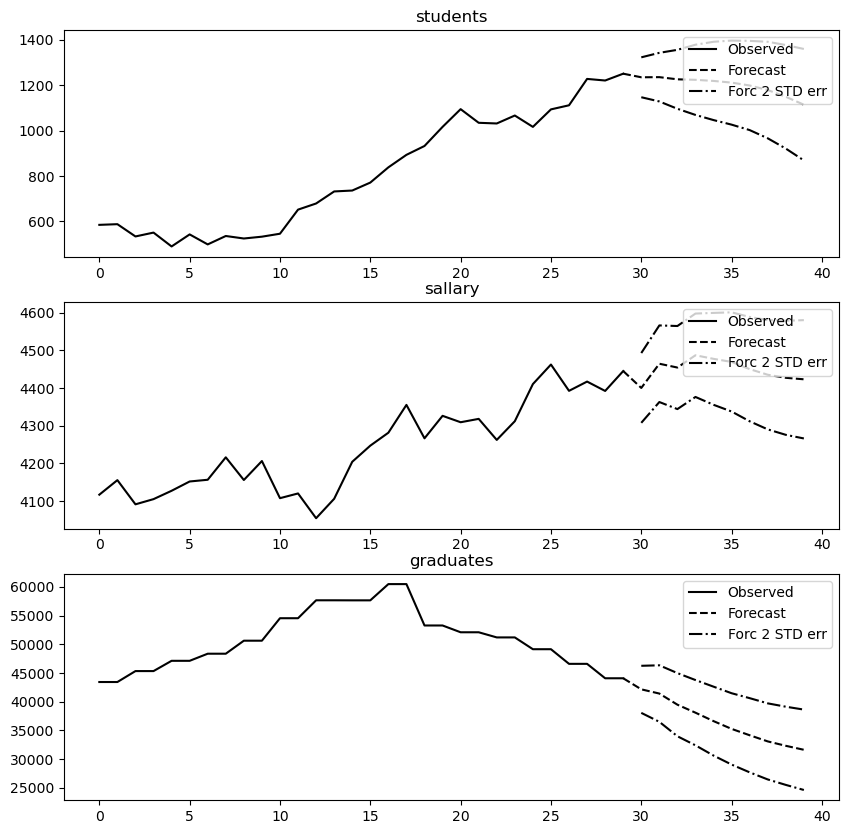

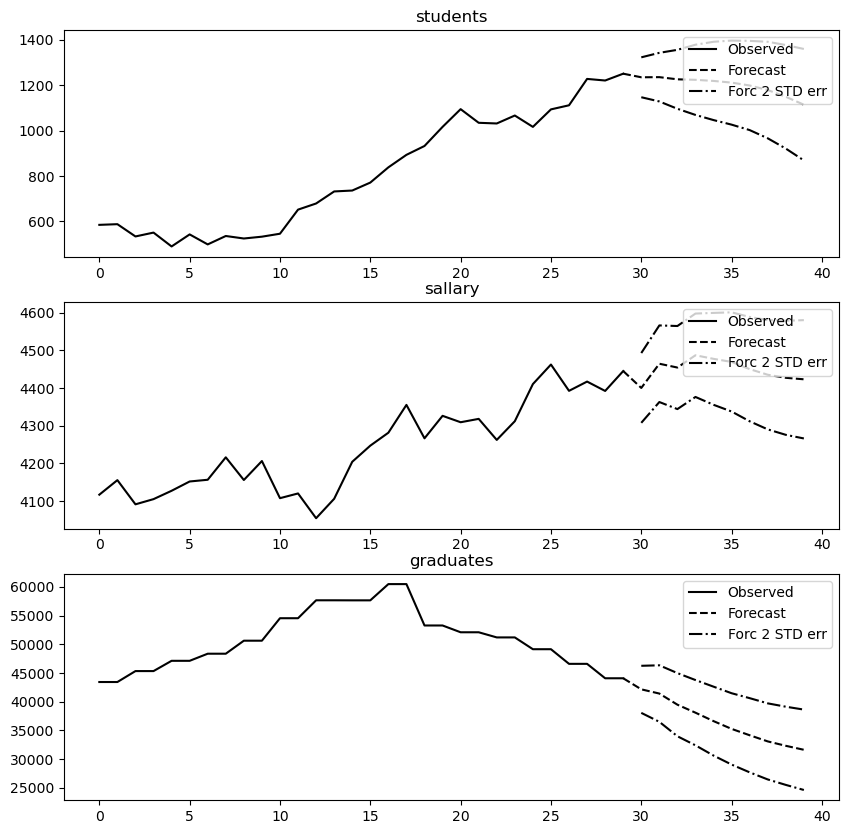

In [13]:
results.plot_forecast(10)

In [14]:
results.test_normality()